In [98]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 
from warnings import filterwarnings
filterwarnings('ignore')

In [99]:
usd_rate = pd.read_excel('kurs_valut.xlsx')
brent_oil = pd.read_excel ('oil_data.xlsx') 

usd_rate.head()

,nominal,data,curs,cdx
0,1,2017-11-01,58.1179,Доллар США
1,1,2017-11-02,58.1557,Доллар США
2,1,2017-11-03,58.0869,Доллар США
3,1,2017-11-04,58.4296,Доллар США
4,1,2017-11-08,58.4557,Доллар США


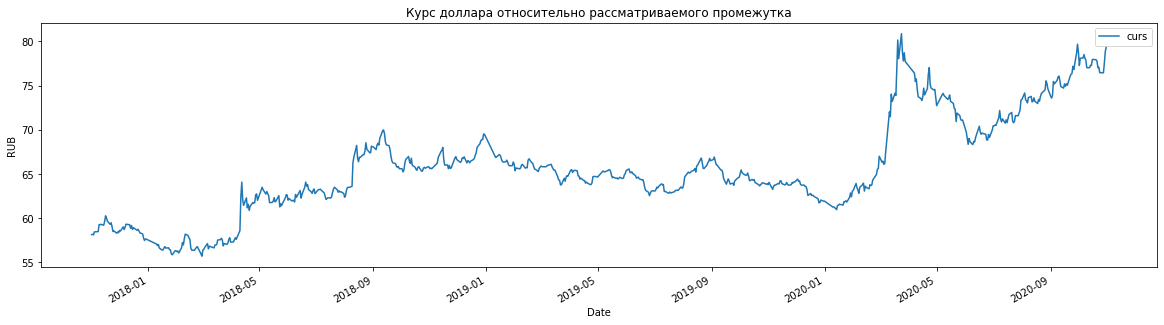

In [100]:
usd_rate['data'] = pd.to_datetime(usd_rate['data'])
usd_rate.plot(x='data',y='curs',figsize=(20, 5))  
plt.xlabel('Date')
plt.ylabel('RUB')
plt.title('Курс доллара относительно рассматриваемого промежутка')
plt.show()

In [101]:
brent_oil.head()

,Sourcekey,RBRTE
0,Date,Europe Brent Spot Price FOB (Dollars per Barrel)
1,1987-05-20 00:00:00,18.63
2,1987-05-21 00:00:00,18.45
3,1987-05-22 00:00:00,18.55
4,1987-05-25 00:00:00,18.6


In [102]:
brent_oil.columns = ['Date', 'Dollars per Barrel']
brent_oil.drop(brent_oil.index[:1], inplace=True)
brent_oil['Date'] = pd.to_datetime(brent_oil['Date'])
brent_oil.head()

,Date,Dollars per Barrel
1,1987-05-20,18.63
2,1987-05-21,18.45
3,1987-05-22,18.55
4,1987-05-25,18.6
5,1987-05-26,18.63


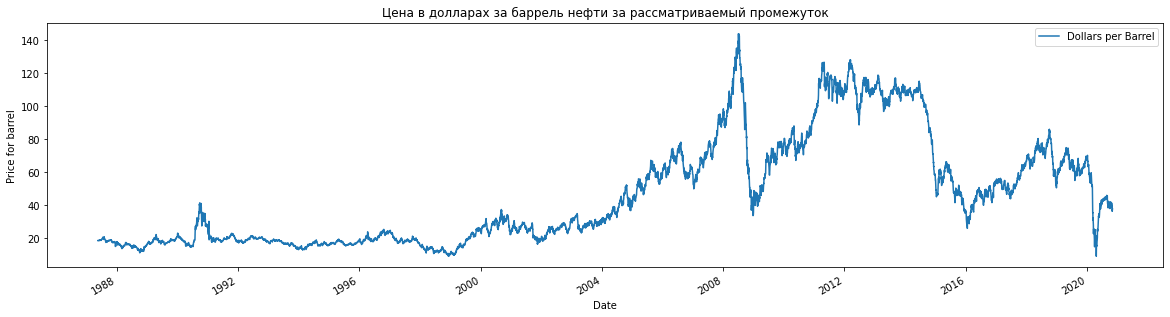

In [103]:
brent_oil.plot(x='Date',y='Dollars per Barrel',figsize=(20, 5))  
plt.xlabel('Date')
plt.ylabel('Price for barrel')
plt.title('Цена в долларах за баррель нефти за рассматриваемый промежуток')
plt.show()

In [104]:
# Трансформация данных
df = usd_rate.set_index('data').join(brent_oil.set_index('Date')) 
df.drop(['nominal', 'cdx'], axis=1, inplace=True)  # Удаляем колонки с ненужной информацией
df.reset_index(inplace=True)
df.columns = ['Date', 'Curs','Dollars per Barrel']
df.head()

,Date,Curs,Dollars per Barrel
0,2017-11-01,58.1179,60.98
1,2017-11-02,58.1557,60.79
2,2017-11-03,58.0869,61.42
3,2017-11-04,58.4296,NaN
4,2017-11-08,58.4557,63.96


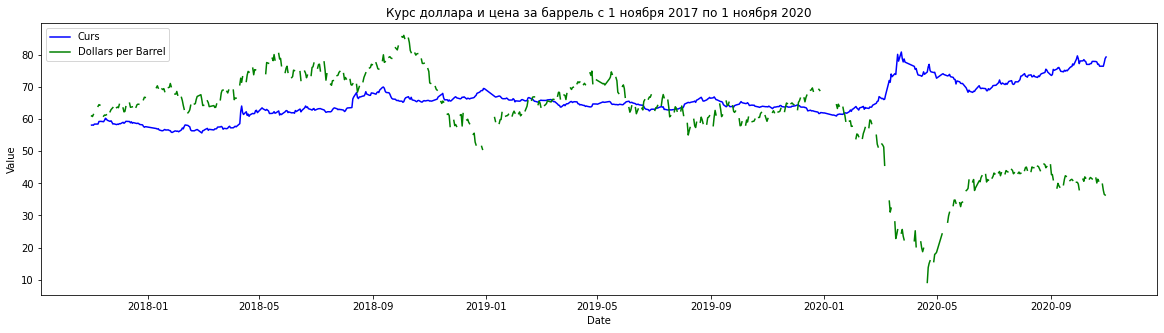

In [105]:
x = df['Date']
y1 = df['Curs']
y2 = df['Dollars per Barrel']

plt.figure(figsize=(20, 5))
plt.plot(x,y1,'b-',label='Curs')
plt.plot(x,y2,'g-',label='Dollars per Barrel')
plt.title('Курс доллара и цена за баррель с 1 ноября 2017 по 1 ноября 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [106]:
# Заполним пропуски
df.fillna(method="ffill", inplace=True)
df

,Date,Curs,Dollars per Barrel
0,2017-11-01,58.1179,60.98
1,2017-11-02,58.1557,60.79
2,2017-11-03,58.0869,61.42
3,2017-11-04,58.4296,61.42
4,2017-11-08,58.4557,63.96
...,...,...,...
732,2020-10-27,76.4443,39.72
733,2020-10-28,76.4556,37.86
734,2020-10-29,77.5520,36.56
735,2020-10-30,78.8699,36.33


In [107]:
# Создадим новые колонки
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['weekday'] = df['Date'].dt.dayofweek
df.head()

,Date,Curs,Dollars per Barrel,year,month,weekday
0,2017-11-01,58.1179,60.98,2017,11,2
1,2017-11-02,58.1557,60.79,2017,11,3
2,2017-11-03,58.0869,61.42,2017,11,4
3,2017-11-04,58.4296,61.42,2017,11,5
4,2017-11-08,58.4557,63.96,2017,11,2


In [108]:
past_days = 7 # Период оценки для модели
# Создаем цикл, в котором будут последовательно вноситься курс доллара и цена за баррель нефти в течении 7 прошлых дней
for day in range(past_days): 
    n = day+1
    df[f"day_lag_{n}"] = df['Curs'].shift(n)
    df[f"oil_lag_{n}"] = df['Dollars per Barrel'].shift(n)
    df[f"mult_{n}"] = df[f"day_lag_{n}"] * df[f"oil_lag_{n}"] # Произведение рассматриваемых показателей
    
df.tail(1)  

,Date,Curs,Dollars per Barrel,year,month,weekday,day_lag_1,oil_lag_1,mult_1,day_lag_2,...,mult_4,day_lag_5,oil_lag_5,mult_5,day_lag_6,oil_lag_6,mult_6,day_lag_7,oil_lag_7,mult_7
736,2020-10-31,79.3323,36.33,2020,10,5,78.8699,36.33,2865.343467,77.552,...,3036.367596,76.4667,40.71,3112.959357,77.0809,40.71,3137.963439,77.0322,41.28,3179.889216


In [109]:
# Cреднее значение показателей за неделю
df['usd_mean_week'] = df['Curs'].shift(1).rolling(window=7).mean()
df['oil_mean_week'] = df['Dollars per Barrel'].shift(1).rolling(window=7).mean()

df = pd.get_dummies(df, columns=['year', 'month', 'weekday'])
df.tail()

,Date,Curs,Dollars per Barrel,day_lag_1,oil_lag_1,mult_1,day_lag_2,oil_lag_2,mult_2,day_lag_3,...,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
732,2020-10-27,76.4443,39.72,76.4667,40.71,3112.959357,77.0809,40.71,3137.963439,77.0322,...,0,1,0,0,1,0,0,0,0,0
733,2020-10-28,76.4556,37.86,76.4443,39.72,3036.367596,76.4667,40.71,3112.959357,77.0809,...,0,1,0,0,0,1,0,0,0,0
734,2020-10-29,77.5520,36.56,76.4556,37.86,2894.609016,76.4443,39.72,3036.367596,76.4667,...,0,1,0,0,0,0,1,0,0,0
735,2020-10-30,78.8699,36.33,77.5520,36.56,2835.301120,76.4556,37.86,2894.609016,76.4443,...,0,1,0,0,0,0,0,1,0,0
736,2020-10-31,79.3323,36.33,78.8699,36.33,2865.343467,77.5520,36.56,2835.301120,76.4556,...,0,1,0,0,0,0,0,0,1,0


In [110]:
df_learn = df[7:].drop('Date', axis=1) # Удаление строк с неполностью заполненными данными (первые 7 дней)

In [111]:
# Создаем обучающую выборку

X_train = df_learn.drop('Curs', axis=1)[:-20] 
y_train = df_learn.Curs[:-20]

In [112]:
# Создаем тестовую выборку

X_test = df_learn.drop('Curs', axis=1)[-20:]
y_test = df_learn.Curs[-20:]

In [113]:
# Пробная модель

from sklearn.neural_network import MLPRegressor 
from sklearn.metrics import mean_absolute_error

mlp = MLPRegressor(random_state=42, hidden_layer_sizes=(200,200,200), max_iter=1000)

mlp.fit(X_train, y_train)

prediction = mlp.predict(X_test)

MAE = mean_absolute_error(y_test, prediction)

print(f'MAE = {MAE}')

MAE = 1.4709262235514609


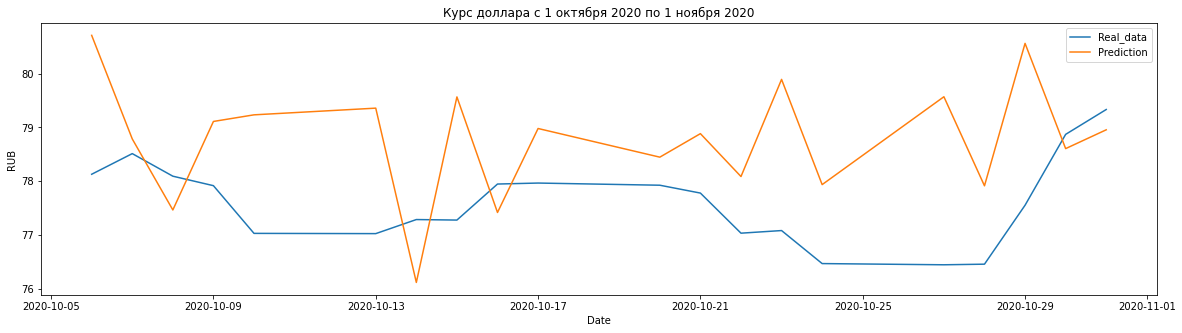

In [114]:
# Cравним предсказания с реальными данными

x = df['Date'][-20:]

plt.figure(figsize=(20, 5))
plt.plot(x, y_test, label = 'Real_data')
plt.plot(x, prediction, label = 'Prediction')
plt.title('Курс доллара с 1 октября 2020 по 1 ноября 2020')
plt.xlabel('Date')
plt.ylabel('RUB')
plt.legend()

In [115]:
# Пробуем получить меньшую ошибку
 
mlp = MLPRegressor(random_state=42, hidden_layer_sizes=(87,87), max_iter=1000)

mlp.fit(X_train, y_train)

prediction = mlp.predict(X_test)

MAE = mean_absolute_error(y_test, prediction)

print(f'MAE= {MAE}')

MAE= 1.1186783293064821


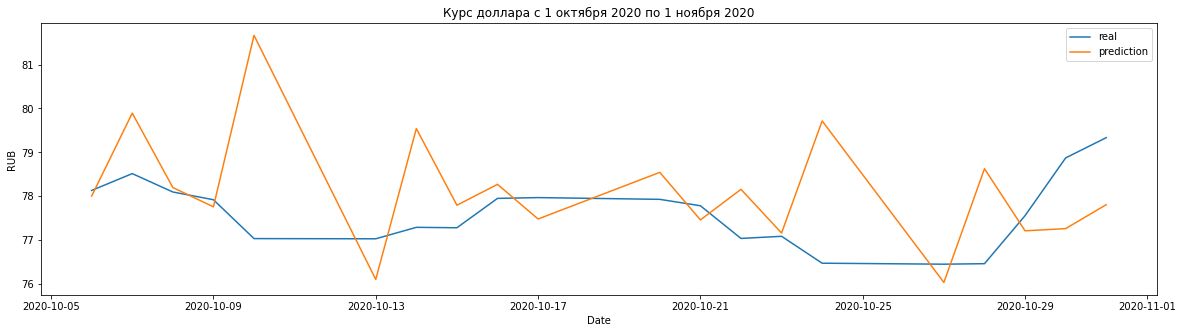

In [116]:
x = df['Date'][-20:]
plt.figure(figsize = (20, 5))
plt.plot(x, y_test, label = 'real')
plt.plot(x, prediction, label = 'prediction')
plt.title('Курс доллара с 1 октября 2020 по 1 ноября 2020')
plt.xlabel('Date')
plt.ylabel('RUB')
plt.legend()
plt.show()

In [117]:
best_mae,best_i,best_g = 1.47,0,0

for i in range(1,5):
    for g in range(1,87):
        model = MLPRegressor(random_state=42, hidden_layer_sizes=(i,g), max_iter=1000)
        model.fit(X_train,y_train)
        prediction = model.predict(X_test)
        mae = mean_absolute_error(prediction,y_test)
        if mae <= best_mae:
            best_mae = mae
            best_i = i
            best_g = g

In [118]:
print(2,15,0.59)

2 15 0.59


In [119]:
# при значении размерности уровней 2 и 15 получили наименьшее значение mae

mlp = MLPRegressor(random_state=42, hidden_layer_sizes=(2,15), max_iter=1000)

mlp.fit(X_train, y_train)

prediction = mlp.predict(X_test)

MAE = mean_absolute_error(y_test, prediction)

print(f'MAE= {MAE}')

MAE= 0.5928274040874719


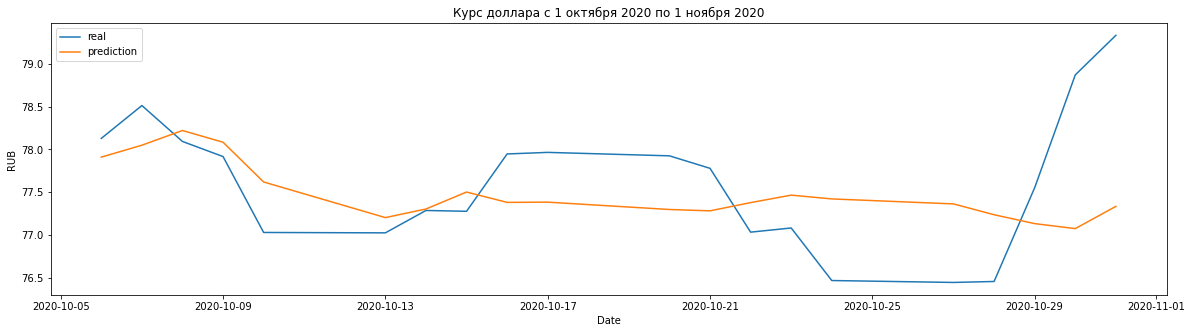

In [120]:
x = df['Date'][-20:]

plt.figure(figsize  =(20, 5))
plt.plot(x, y_test, label = 'real')
plt.plot(x, prediction, label = 'prediction')
plt.title('Курс доллара с 1 октября 2020 по 1 ноября 2020')
plt.xlabel('Date')
plt.ylabel('RUB')
plt.legend()
plt.show()

**Попробуем использовать другие модели регрессии**

In [121]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(random_state=42) # Воспроизводимость выборки
model.fit(X_train,y_train)
prediction = model.predict(X_test)
MAE = mean_absolute_error(prediction, y_test)
print(f'MAE= {MAE}')

MAE= 0.6208669999999991


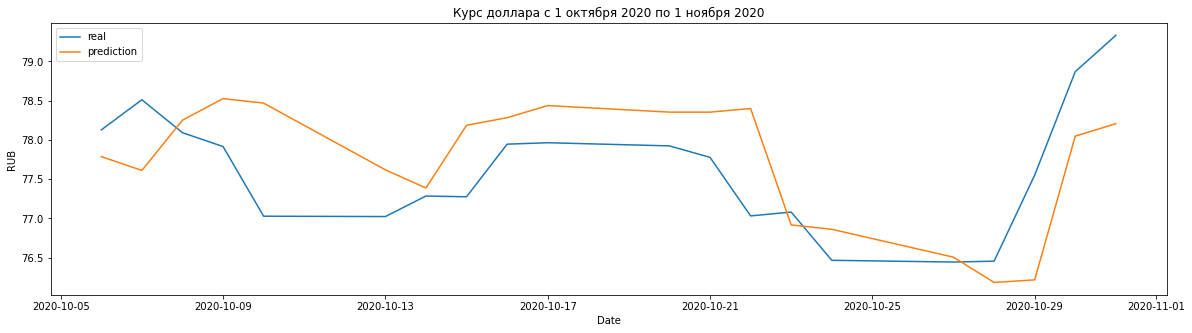

In [122]:
x = df['Date'][-20:]
plt.figure(figsize = (20, 5))
plt.plot(x, y_test, label = 'real')
plt.plot(x, prediction, label = 'prediction')
plt.title('Курс доллара с 1 октября 2020 по 1 ноября 2020')
plt.xlabel('Date')
plt.ylabel('RUB')
plt.legend()
plt.show()

Даже без подбора параметров MAE = 0.62.
Попробуем улучшить через подбор n_estimators

In [123]:
MAE = []
index=[] 
best_i,best_mae = 0, 0.62

for i in range(1,300):
    model = BaggingRegressor(random_state=42, n_estimators=i)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    MAE.append(mean_absolute_error(prediction,y_test))
    index.append(i) #записываем значения MAE и в массивы
    mae=mean_absolute_error(prediction,y_test)
    if mae <= best_mae:
        best_mae = mae
        best_i = i
                
print(31, 0.50)

31 0.5


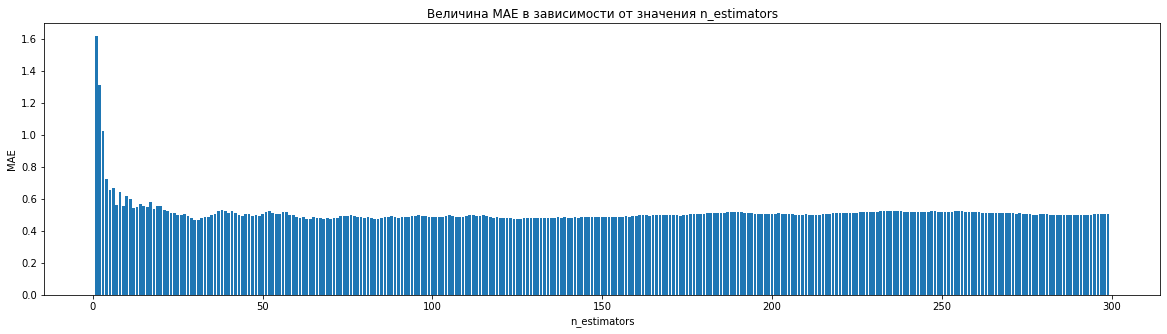

In [124]:
plt.figure(figsize = (20, 5))
plt.bar(index, MAE, label = 'MAE')
plt.title('Величина MAE в зависимости от значения n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.show()

In [125]:
print (MAE[23]) # минимальное значение MAE при n_estimators = 31

0.5095714583333283


**Далее попробуем ARDRegression**

In [126]:
from sklearn.linear_model import ARDRegression

model = ARDRegression() 
model.fit(X_train,y_train)
prediction = model.predict(X_test)
MAE = mean_absolute_error(prediction, y_test)
print(f'MAE = {MAE}')

MAE = 0.3406775559184723


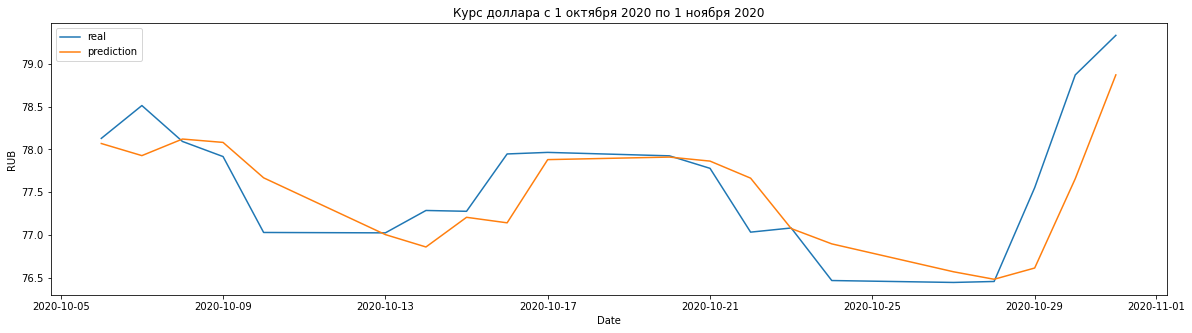

In [127]:
x = df['Date'][-20:]
plt.figure(figsize = (20, 5))
plt.plot(x, y_test, label = 'real')
plt.plot(x, prediction, label = 'prediction')
plt.title('Курс доллара с 1 октября 2020 по 1 ноября 2020')
plt.xlabel('Date')
plt.ylabel('RUB')
plt.legend()

In [128]:
MAE = []
index=[] 
best_i,best_mae = 0, 0.62

for i in range(1,100):
    model = ARDRegression(n_iter=i) 
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    MAE.append(mean_absolute_error(prediction,y_test))
    index.append(i)
    mae=mean_absolute_error(prediction,y_test)
    if mae <= best_mae:
        best_mae = mae
        best_i = i
        
print(best_i,best_mae)

10 0.34047062196626


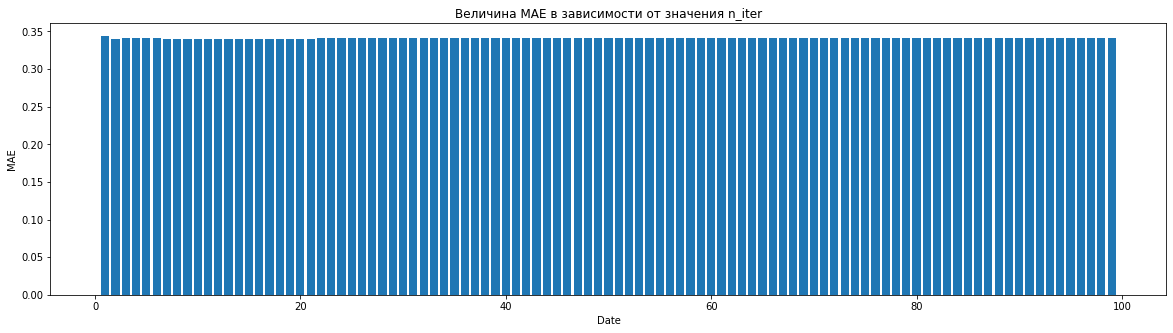

In [129]:
plt.figure(figsize = (20, 5))
plt.bar(index, MAE, label = 'MAE')
plt.title('Величина MAE в зависимости от значения n_iter')
plt.xlabel('Date')
plt.ylabel('MAE')
plt.show()

**Попробуем предсказать данные на 7 дней вперед, в новой таблице будут стобцы с данными прошлых 7 дней и 7 дней следующих которые будут предсказываться**

In [138]:
trange = 7
tb = []
past_col = []
futr_col = []

for i in range(trange,len(usd_rate)-trange):
    t = (usd_rate.curs[(i-trange):(i+trange)])
    tb.append(list(t))

for i in range(trange):
    past_col.append(f'past_{i}')
    futr_col.append(f'futr_{i}')

data = pd.DataFrame(tb, columns = (past_col+futr_col))

# Обучающая выборка (тренировочная) 
X = data[past_col][:-20] 
Y = data[futr_col][:-20] 

# Тестовая (проверочная)
X_test = data[past_col][-20:]
Y_test = data[futr_col][-20:]

In [139]:
# Попробуем модель MLPRegressor

model = MLPRegressor(random_state=42) 
model.fit(X,Y)
prediction = model.predict(X_test)
MAE = mean_absolute_error(prediction, Y_test)
print(f'MAE = {MAE}') 

MAE = 0.9360775213110691


**Выводы:**

1. Лучший результат в предсказание курса показала модель ARDRegression , со значением MAE = 0.35

2. Модель предсказывающая на несколько дней вперёд имеет результат MAE = 0.94

3. Изменяя параметры работы модели мы можем в разы изменить её точность, необходимо больше времени для изучения всех параметров каждой модели и тем не менее даже 1 параметр модели может улучшить результат.